# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9432\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4852.15,1.00,-131.89,2667.23,2535.34
OMUSDT,526.32,3342.11,0.69,0.00,2815.79,2815.79
BTCUSDT,601.02,743.15,0.15,3.54,142.13,145.67
SOLUSDT,281.20,240.83,0.05,0.00,-40.37,-40.37
JASMYUSDT,387.46,235.77,0.05,0.00,-151.69,-151.69
ETHUSDT,250.75,160.43,0.03,0.00,-90.31,-90.31
TRXUSDT,76.87,109.79,0.02,-10.72,32.93,22.21
BBUSDT,60.18,19.03,0.00,-39.73,-41.14,-80.87
BNBUSDT,1.14,1.03,0.00,-10.61,-0.11,-10.72
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

453

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-02-21    2948.219021
2025-02-22    3289.308216
2025-02-23    3399.596486
2025-02-24    3026.062999
2025-02-25    3012.444225
Name: Total, Length: 156, dtype: float64

In [39]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-02-21   -269.504244
2025-02-22    341.089195
2025-02-23    110.288270
2025-02-24   -373.533487
2025-02-25    -13.618774
Name: Total, Length: 156, dtype: float64

In [40]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [41]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [42]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [43]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_9432\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [44]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [45]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [46]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

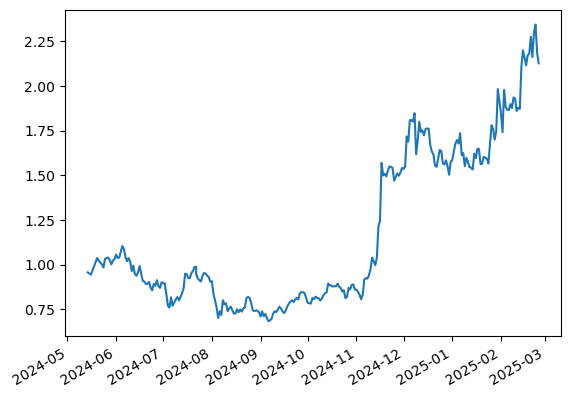

In [47]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

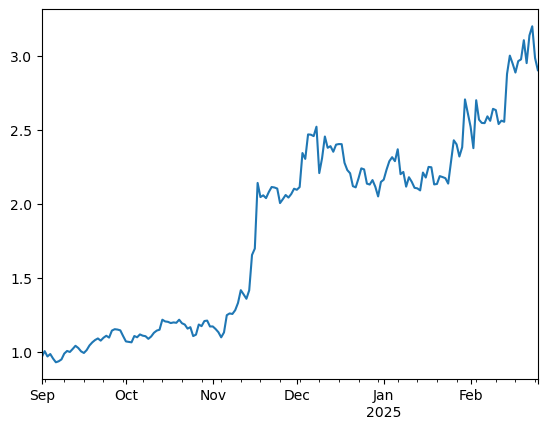

In [48]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [50]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [53]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [54]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [57]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.5655
BNBUSDT,0.2037
XRPUSDT,0.0720
DEXEUSDT,0.0688
AAVEUSDT,0.0350
PEPEUSDT,0.0266
SUIUSDT,0.0223
ADAUSDT,0.0062
TRXUSDT,0.0000
WBTCUSDT,0.0000


In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

In [59]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

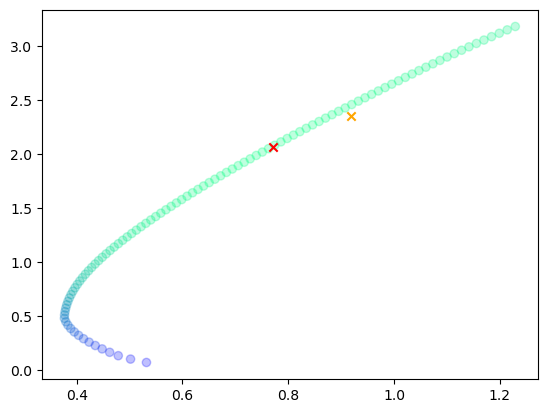

In [60]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [61]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [62]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3342.106537,0.688788,0.2757,0.413088
BTCUSDT,743.146803,0.153158,0.0000,0.153158
SOLUSDT,240.832501,0.049634,0.0000,0.049634
JASMYUSDT,235.773180,0.048591,0.0000,0.048591
ETHUSDT,160.433913,0.033064,0.0000,0.033064
TRXUSDT,109.794845,0.022628,0.0000,0.022628
BBUSDT,19.033394,0.003923,0.0000,0.003923
BNBUSDT,1.033246,0.000213,0.1166,-0.116387
PEPEUSDT,0.000002,0.000000,0.0282,-0.028200
DEXEUSDT,0.000000,0.000000,0.0714,-0.071400


### Current results

In [64]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [65]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']

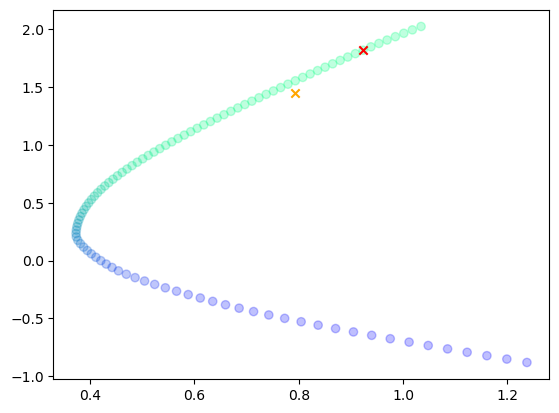

In [66]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [67]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3342.106537,0.688788,0.863765,-0.174977
BTCUSDT,743.146803,0.153158,0.000000,0.153158
SOLUSDT,240.832501,0.049634,0.000000,0.049634
JASMYUSDT,235.773180,0.048591,0.000000,0.048591
ETHUSDT,160.433913,0.033064,0.000000,0.033064
TRXUSDT,109.794845,0.022628,0.136235,-0.113607
BBUSDT,19.033394,0.003923,0.000000,0.003923
BNBUSDT,1.033246,0.000213,0.000000,0.000213
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [69]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [70]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

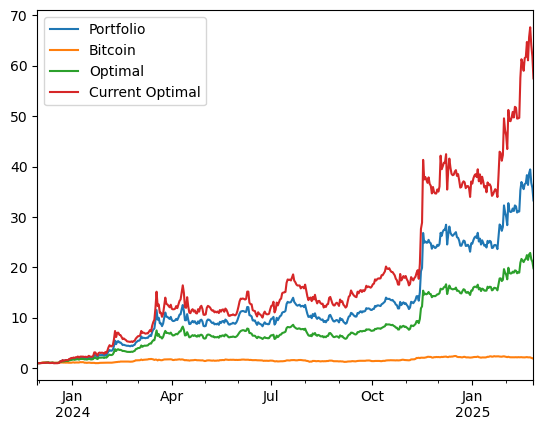

In [71]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [72]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

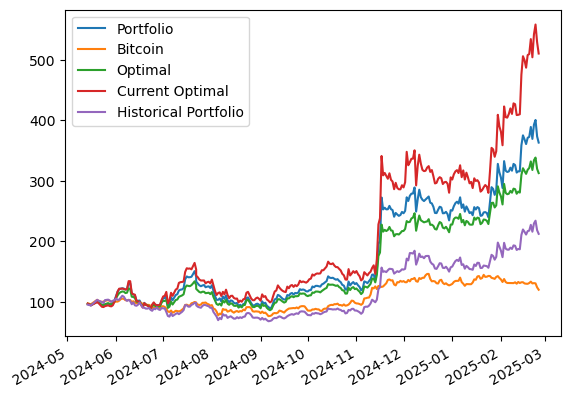

In [73]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [74]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-02-16,368.634687,130.705625,316.222785,499.441221,215.906817
2025-02-17,360.898486,130.245024,311.681572,487.057063,211.469567
2025-02-18,371.264008,130.097725,318.427398,507.863197,217.110239
2025-02-19,372.680556,131.413663,321.361875,509.515320,217.982078
2025-02-20,389.102434,133.652549,332.247442,534.210840,227.454796
2025-02-21,369.405310,130.734531,318.031255,504.193653,216.124900
2025-02-22,392.963136,131.235172,334.171948,542.177665,229.824326
2025-02-23,400.710062,130.836298,338.579180,558.291386,234.337855
2025-02-24,373.548979,124.279390,319.931447,529.087568,218.637163
2025-02-25,363.321613,120.317632,312.942272,510.380877,212.638330


## Volatilities

In [76]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.732406
 dtype: float64,
 0.7331915334853398)

In [77]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.792078
 dtype: float64,
 0.7920779866687062)

In [78]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.918483
Bitcoin            0.423517
Optimal            0.733192
Current Optimal    1.081073
dtype: float64

In [79]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.475884782346958

In [80]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.171020370675683

In [81]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.8302039031363875

## Risk Contribution

In [83]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.094073,0.079385,0.003809,0.019897,0.002621,0.017276
BTCUSDT,0.268877,0.300000,0.012493,0.091959,0.030030,0.061929
DEXEUSDT,0.108151,0.059471,0.003681,0.028338,0.005509,0.022829
OMUSDT,44.011679,0.521903,0.977987,0.845808,0.765770,0.080039
SUIUSDT,0.010217,0.008880,0.000419,0.003714,0.000134,0.003581
XRPUSDT,0.042986,0.030361,0.001611,0.010285,0.000787,0.009497


In [84]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,4.135475,0.863765,0.965239,0.961583,0.937144,0.024438
TRXUSDT,0.043802,0.136235,0.034761,0.038417,0.013979,0.024438


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.336903,0.696970,0.932257,0.896772,0.828811,0.067961
BTCUSDT,0.033276,0.151515,0.042707,0.036713,0.005829,0.030885
SOLUSDT,-0.015038,0.050505,0.008197,0.022317,0.001864,0.020453
JASMYUSDT,-0.024345,0.050505,0.006046,0.030259,0.004867,0.025392
ETHUSDT,-0.010298,0.030303,0.004623,0.008530,0.000444,0.008086
TRXUSDT,0.006495,0.020202,0.006170,0.005408,0.000418,0.004990


# Value At Risk

## Historical

### Optimal Weights

In [89]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05547026817984901, -0.08128716738251147)

### Current Weights

In [91]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05427412392212481, -0.08141179599172994)

In [92]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [93]:
var=historical_var.iloc[row]
var

OMUSDT      -0.038177
BTCUSDT     -0.004485
SOLUSDT     -0.002309
JASMYUSDT   -0.006483
ETHUSDT     -0.002510
TRXUSDT     -0.001618
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.055582
Name: 2025-02-02 00:00:00, dtype: float64

In [94]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.067468
BTCUSDT     -0.004564
SOLUSDT     -0.003096
JASMYUSDT   -0.004111
ETHUSDT     -0.001521
TRXUSDT     -0.000651
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.081412
dtype: float64

## Parametric

### Optimal Weights

In [97]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07597040256328354, -0.09737305143312701)

### Current Weights

In [99]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08207198359572974, -0.10519359132299878)

## Multivariate

### Optimal Weights

In [102]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06853964028341124, -0.08787473140598855)

### Current Weights

In [104]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07727677611393928, -0.09758764574842146)

In [105]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.066890
BTCUSDT     -0.003609
SOLUSDT     -0.001811
JASMYUSDT   -0.002783
ETHUSDT     -0.000733
TRXUSDT     -0.000211
Portfolio   -0.076038
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [109]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06774949114550513, -0.08750807189315044)

### Current Weights

In [111]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07663408594165337, -0.0984601541416518)

In [112]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.066823
BTCUSDT     -0.003859
SOLUSDT     -0.002264
JASMYUSDT   -0.002443
ETHUSDT     -0.000817
TRXUSDT     -0.000276
Portfolio   -0.076484
dtype: float64

## Student Copula

### Optimal Weights

In [115]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06839828145894561, -0.08748515198740593)

### Current Weights

In [117]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07759640760454928, -0.10054551612570461)

In [118]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.069507
BTCUSDT     -0.002971
SOLUSDT     -0.001912
JASMYUSDT   -0.002387
ETHUSDT     -0.000697
TRXUSDT     -0.000362
Portfolio   -0.077836
dtype: float64

## Gumbel Copula

### Optimal Weights

In [121]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.14376086099249508, -0.20237200585463794)

### Current Weights

In [123]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15890391337346066, -0.2264223057197412)

In [124]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.158189
BTCUSDT     -0.003104
SOLUSDT      0.000071
JASMYUSDT    0.000541
ETHUSDT     -0.000017
TRXUSDT     -0.000039
Portfolio   -0.160737
dtype: float64

## Monte Carlo

### Optimal

In [127]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [128]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0777955430976345, -0.0967186957148221)

### Current Weights

In [130]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08400555233835842, -0.10412329254732226)

In [131]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.075305
BTCUSDT     -0.002696
SOLUSDT     -0.001702
JASMYUSDT   -0.002920
ETHUSDT     -0.000747
TRXUSDT     -0.000419
Portfolio   -0.083788
dtype: float64

## VaR Violation

In [133]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.063830,-0.115620,-0.096906,-0.022048
2024-01-15,-0.063830,-0.115590,-0.095341,0.017671
2024-01-16,-0.063830,-0.116038,-0.098647,0.060298
2024-01-17,-0.063830,-0.118501,-0.097433,-0.037490
2024-01-18,-0.063830,-0.120429,-0.105065,-0.031923
...,...,...,...,...
2025-02-22,-0.049808,-0.110943,-0.093971,0.050752
2025-02-23,-0.049808,-0.109825,-0.094563,0.013189
2025-02-24,-0.053697,-0.109792,-0.098771,-0.055076
2025-02-25,-0.053697,-0.107527,-0.100268,-0.021846


In [134]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045305,-0.084377,-0.082860,-0.015293
2024-05-29,-0.045305,-0.082240,-0.082026,-0.007207
2024-05-30,-0.045305,-0.072636,-0.070850,0.027701
2024-05-31,-0.045305,-0.076942,-0.072384,0.050457
2024-06-01,-0.045305,-0.083973,-0.079156,0.067907
...,...,...,...,...
2025-02-22,-0.048855,-0.108726,-0.093233,0.063772
2025-02-23,-0.048855,-0.107013,-0.092430,0.019714
2025-02-24,-0.065380,-0.117486,-0.110452,-0.067782
2025-02-25,-0.065380,-0.119303,-0.109025,-0.027379


<Axes: >

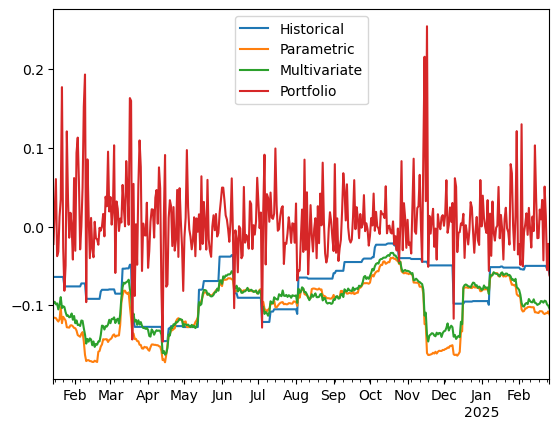

In [135]:
var_data.plot()

<Axes: >

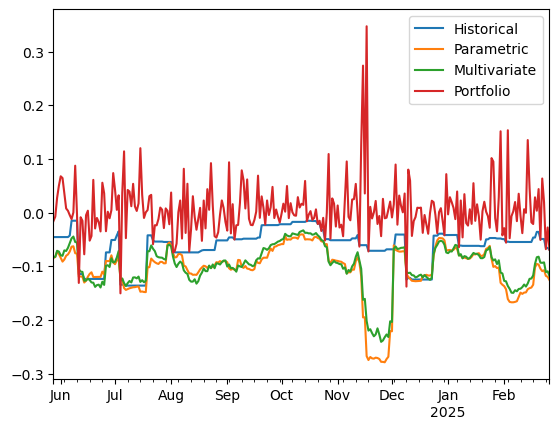

In [136]:
current_var_data.plot()

In [137]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031707,0.007317,0.007317
Kupiec Stat,3.301134,24.243871,24.243871
P-value,0.069232,0.000001,0.000001


In [138]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.065455,0.010909,0.010909
Kupiec Stat,1.265502,12.80184,12.80184
P-value,0.260612,0.000346,0.000346


# Principal Component Analysis

## Historical PCA

In [141]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79030857, 0.06837631, 0.05317269, 0.04780429, 0.04033814])

In [142]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.016968
ADAUSDT      0.016707
ALGOUSDT     0.019289
APTUSDT      0.017428
ARBUSDT      0.018835
ATOMUSDT     0.017114
AVAXUSDT     0.018739
BCHUSDT      0.015610
BNBUSDT      0.008848
BONKUSDT     0.023696
BTCUSDT      0.009476
DEXEUSDT     0.014236
DOGEUSDT     0.018144
DOTUSDT      0.017783
ENSUSDT      0.020611
EOSUSDT      0.017878
ETCUSDT      0.016173
ETHUSDT      0.012911
FDUSDUSDT    0.000046
FETUSDT      0.022402
FILUSDT      0.019631
FLOKIUSDT    0.023846
FLOWUSDT     0.018967
GALAUSDT     0.023149
GRTUSDT      0.021332
HBARUSDT     0.018550
ICPUSDT      0.017381
IMXUSDT      0.019535
INJUSDT      0.020206
IOTAUSDT     0.020221
JASMYUSDT    0.020534
LDOUSDT      0.020148
LINKUSDT     0.016941
LTCUSDT      0.012887
MKRUSDT      0.013252
NEARUSDT     0.021117
NEXOUSDT     0.011226
OMUSDT       0.011047
OPUSDT       0.019443
PEPEUSDT     0.024484
QNTUSDT      0.015247
SANDUSDT     0.021009
SEIUSDT      0.020988
SHIBUSDT     0.018452
SOLUSDT      0.015363
STXUSDT   

<Axes: >

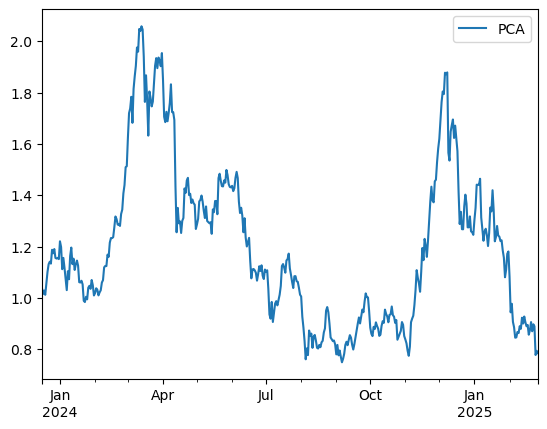

In [143]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

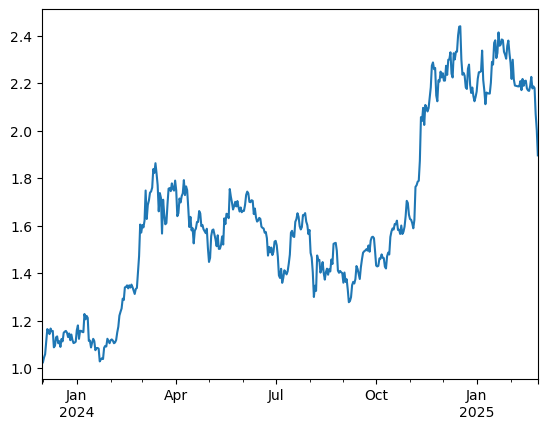

In [144]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [145]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.428600
WBETHUSDT    0.454294
ETHUSDT      0.454451
ATOMUSDT     0.467813
DOTUSDT      0.472249
ETCUSDT      0.472793
NEXOUSDT     0.495416
ADAUSDT      0.527997
EOSUSDT      0.529133
AVAXUSDT     0.539043
WBTCUSDT     0.544870
BTCUSDT      0.545076
IOTAUSDT     0.554455
FILUSDT      0.560127
ARBUSDT      0.573080
GRTUSDT      0.579745
XTZUSDT      0.586285
LINKUSDT     0.599183
IMXUSDT      0.619315
dtype: float64

<Axes: >

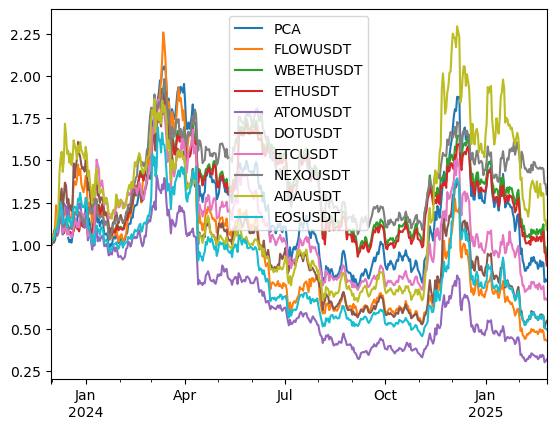

In [146]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

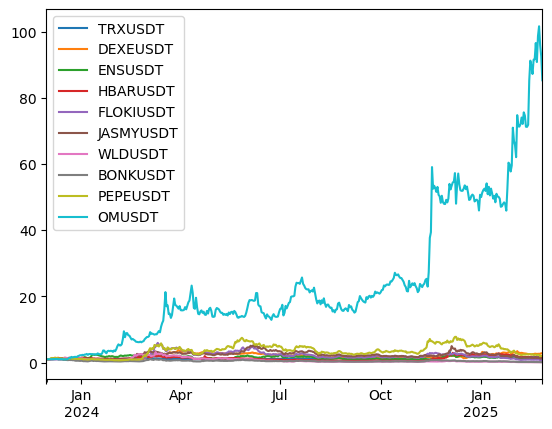

In [147]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [149]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.57436397, 0.14886365, 0.11562074, 0.09264533, 0.06850631])

In [150]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095589
BTCUSDT      0.058643
SOLUSDT      0.100488
JASMYUSDT    0.174537
ETHUSDT      0.085820
TRXUSDT      0.053676
BBUSDT       0.204138
BNBUSDT      0.066085
PEPEUSDT     0.161025
Name: PC1, dtype: float64

<Axes: >

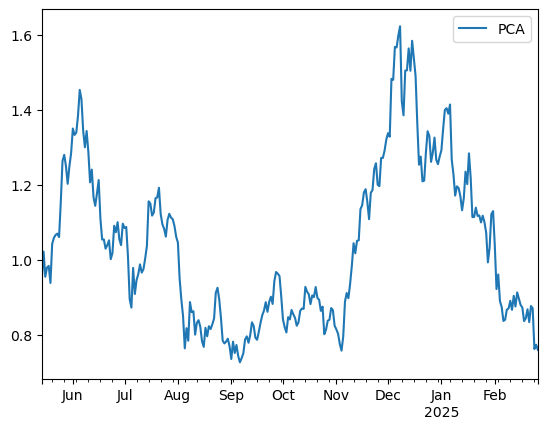

In [151]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

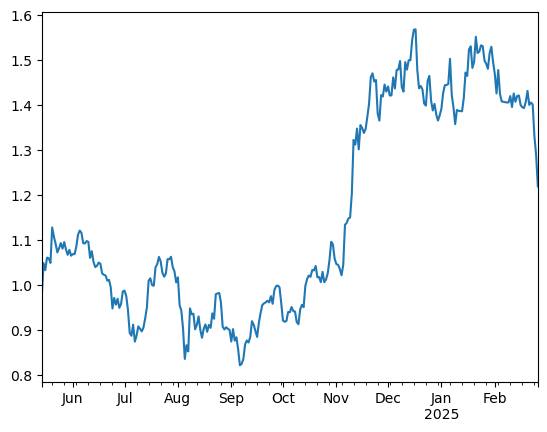

In [152]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.444260
BNBUSDT      0.484787
SOLUSDT      0.503538
BTCUSDT      0.506756
JASMYUSDT    0.697881
PEPEUSDT     0.751076
BBUSDT       0.793240
TRXUSDT      0.922049
OMUSDT       1.005879
dtype: float64

<Axes: >

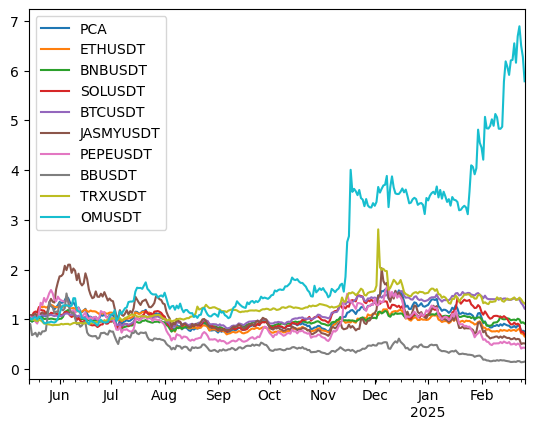

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [156]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.893315
BBUSDT       1.538311
JASMYUSDT    1.346169
SOLUSDT      1.181447
BTCUSDT      1.000000
ETHUSDT      0.985919
OMUSDT       0.915607
BNBUSDT      0.669510
TRXUSDT      0.338181
Name: BTCUSDT, dtype: float64

In [157]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT       2.479705
JASMYUSDT    2.064747
BBUSDT       1.641289
PEPEUSDT     1.620485
SOLUSDT      1.569988
ETHUSDT      1.352446
BTCUSDT      1.000000
BNBUSDT      0.909787
TRXUSDT      0.817488
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [159]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [160]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BBUSDT,0.214727
BTCUSDT,0.184789
PEPEUSDT,0.183835
JASMYUSDT,0.131527
ETHUSDT,0.102014
SOLUSDT,0.098064
TRXUSDT,0.088272
BNBUSDT,0.038753
OMUSDT,0.002789


### Regression to PCA

In [162]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.5827885130759614

In [163]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.293799
BNBUSDT      1.143412
ETHUSDT      1.013869
PCA          1.000000
SOLUSDT      0.734176
JASMYUSDT    0.451083
PEPEUSDT     0.428325
BBUSDT       0.392299
TRXUSDT      0.261520
OMUSDT       0.240303
dtype: float64

In [164]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.525640
BNBUSDT      1.065153
ETHUSDT      1.063333
PCA          1.000000
TRXUSDT      0.962596
SOLUSDT      0.828573
PEPEUSDT     0.645699
BBUSDT       0.592169
JASMYUSDT    0.563029
OMUSDT       0.331978
dtype: float64

### Correlation Matrix

<Axes: >

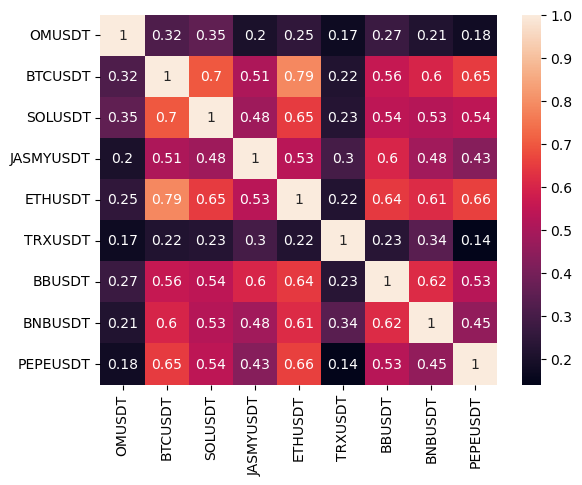

In [166]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

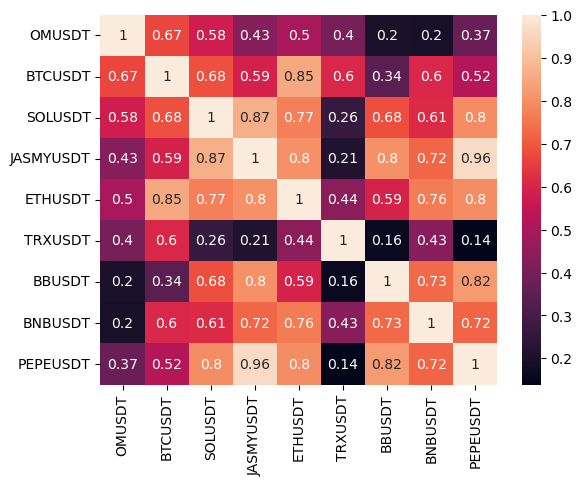

In [167]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [169]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [170]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-07-21,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051136,...,0.668893,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-08-20,0.318026,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.681974,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-09-19,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-19,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.137951,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-18,0.000000,0.116256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200357,0.024123,0.0
2024-12-18,0.479987,0.055860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.314886,0.0
2025-01-17,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.638746,0.0
2025-02-16,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-02-26,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [171]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

MKRUSDT     0.540635
DEXEUSDT    0.457354
ADAUSDT     0.002012
SOLUSDT     0.000000
LINKUSDT    0.000000
LTCUSDT     0.000000
Name: 2025-02-26 00:00:00, dtype: float64